In [2]:
from fastai.vision.all import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype

import matplotlib as mpl
import json

# mpl.rcParams['figure.dpi']= 200
mpl.rcParams['savefig.dpi']= 200
mpl.rcParams['font.size']=12

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.set_option('display.max_columns',999)
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

def get_image_files_sorted(path, recurse=True, folders=None): return get_image_files(path, recurse, folders).sorted()


# +
!pip install azure-cognitiveservices-search-imagesearch

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])


# -

def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass


def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

# +
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))


# +
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e4709a4cabe64536808467125235874c')

In [4]:
results = search_images_bing(key, 'Chinese cuisine')
ims = results.attrgot('contentUrl')
len(ims)

149

In [5]:
#ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [6]:
from fastdownload import download_url 
dest = 'images/Chinese.jpg'
download_url(ims[0], dest)

Path('images/Chinese.jpg')

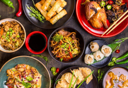

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
cuisine_types = 'Chinese','Korean','Japanese'
path = Path('cuisine')

In [9]:
if not path.exists():
    path.mkdir()
    for o in cuisine_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cuision ')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#432) [Path('cuisine/Chinese/e6ccc93e-cad5-4466-918b-a68d2e30646d.jpeg'),Path('cuisine/Chinese/e3f7b34e-f9ec-40a6-a33a-d1face3bbbd7.jpg'),Path('cuisine/Chinese/d02596fc-0ae2-4bc3-bd26-203cf6c73873.jpeg'),Path('cuisine/Chinese/7b4d9081-f2ee-4ebd-a410-8a9fec848a79.jpg'),Path('cuisine/Chinese/4c48f60d-5c3c-4818-bf95-fcbaea1334a4.jpg'),Path('cuisine/Chinese/d2d6da95-94cb-4471-bd10-ce41bd484ab6.JPG'),Path('cuisine/Chinese/f13a8f79-1742-4c28-96a3-869fe104940d.jpg'),Path('cuisine/Chinese/b153b279-1bbb-4b80-8394-7616b01b5dfb.jpg'),Path('cuisine/Chinese/3a7227df-5b81-4ebd-a2f4-df4d30dfa914.jpeg'),Path('cuisine/Chinese/32d4670c-ff3c-4728-b8dc-a68c2984fec5.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#12) [Path('cuisine/Chinese/7b4d9081-f2ee-4ebd-a410-8a9fec848a79.jpg'),Path('cuisine/Chinese/5d575c9f-1e3e-4bd5-8cef-161699d3ad4d.jpg'),Path('cuisine/Chinese/e4b7bbd1-8df4-4553-aa0a-8325c91fb492.png'),Path('cuisine/Chinese/bb9f093e-d0a7-4902-9edb-52531f153012.jpg'),Path('cuisine/Chinese/f5d3fc1c-42c4-4775-a217-edae7435e775.jpg'),Path('cuisine/Korean/eefa4f12-e6e3-47a2-a684-c34d96e01a4f.jpg'),Path('cuisine/Korean/b8f3f691-169d-4bf0-8e31-e2dc2bdfdf80.jpg'),Path('cuisine/Korean/519d9044-e65c-4fe0-b240-e94d4c717785.jpg'),Path('cuisine/Korean/d2962eea-fa2c-4c42-ae00-502b77bd0679.jpg'),Path('cuisine/Japanese/32191bd6-d1e0-4e93-af83-f21ad7e9bd3d.jpg')...]

In [12]:
failed.map(Path.unlink);

In [13]:
!pip install -Uqq fastbook

from fastai.data.all import *
from fastai.vision.all import *
import fastbook

fastbook.setup_book() 

In [14]:
cuisine = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = cuisine.dataloaders(path)

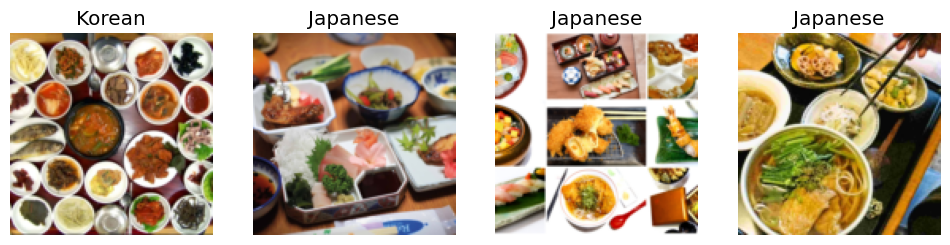

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

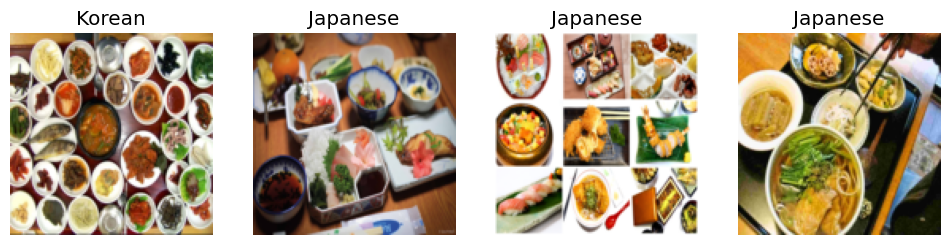

In [17]:
cuisine = cuisine.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cuisine.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

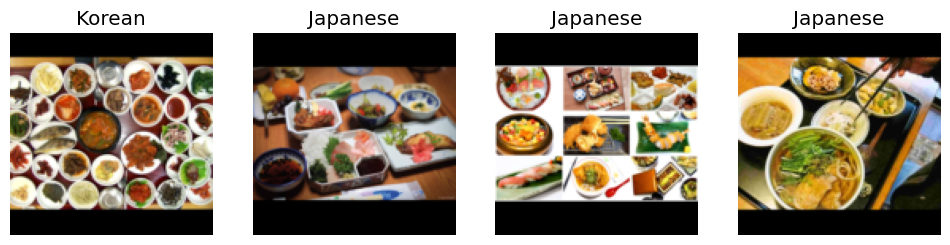

In [18]:
cuisine = cuisine.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cuisine.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

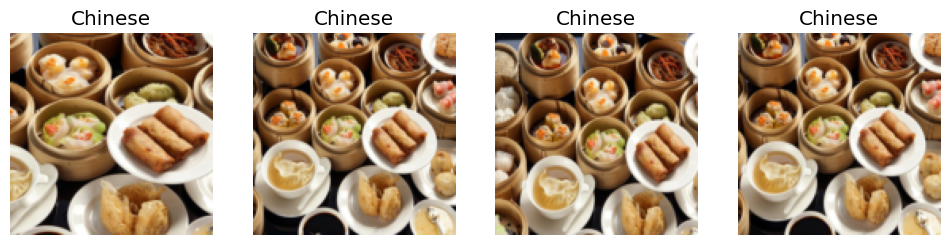

In [19]:
cuisine = cuisine.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cuisine.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [20]:
!conda install -c pytorch magma-cuda110 -y

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - magma-cuda110


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    magma-cuda110-2.5.2        |                1        65.2 MB  pytorch
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        68.0 MB

The following NEW packages will be INSTALLED:

  magma-cuda110      pytorch/linux-64::magma-cuda110-2.5.2-1 


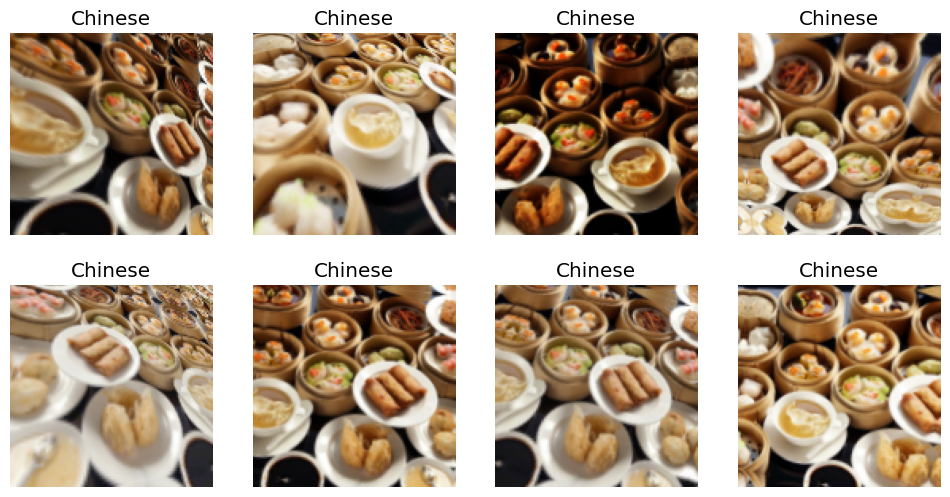

In [21]:
cuisine = cuisine.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cuisine.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train the model and use it to clean data

In [22]:
cuisine = cuisine.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cuisine.dataloaders(path)

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.732125,1.447028,0.559524,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.332219,1.195206,0.404762,00:15
1,1.145072,1.180588,0.452381,00:15
2,1.039147,1.164068,0.440476,00:14
3,0.941625,1.151068,0.440476,00:17


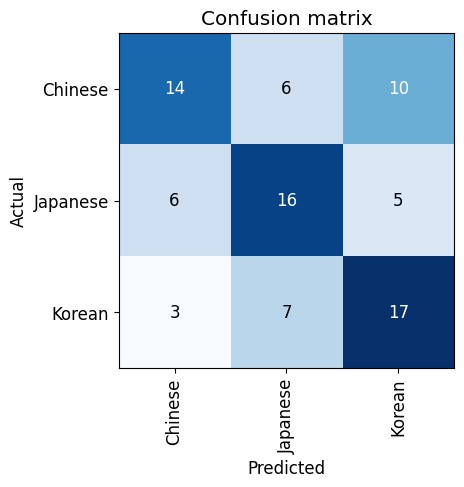

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

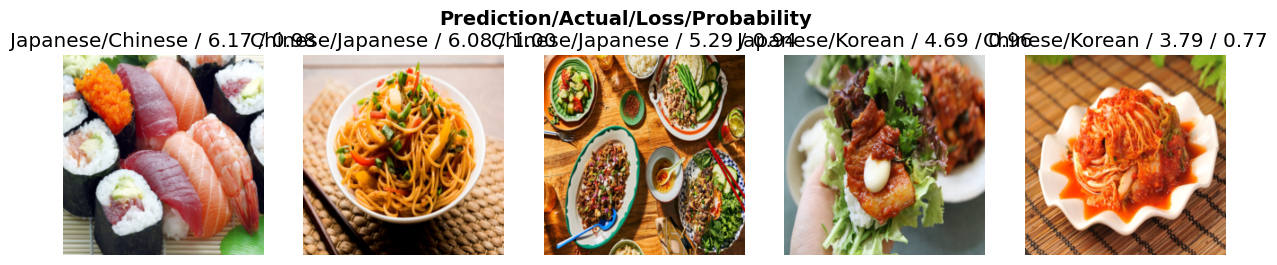

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: name 'ImageClassifierCleaner' is not defined

# Turning the model into an online application

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/Chinese.jpg')

('Chinese', tensor(0), tensor([0.9822, 0.0029, 0.0149]))

In [32]:
learn_inf.dls.vocab

['Chinese', 'Japanese', 'Korean']

# Creating a Notebook App from the Model

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/Chinese.jpg'])

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Chinese; Probability: 0.9822')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
btn_upload = widgets.FileUpload()

In [43]:
from ipywidgets import *
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])